## Import packages

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model
from preprocess import water_postprocess, water_process_no_norm
from scipy import stats
from scipy.stats import mannwhitneyu, wilcoxon, ttest_rel
from scipy.stats import gaussian_kde
from performance import metrics_s1_t1
from helper import series_to_supervised

2024-02-06 14:53:54.666595: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"

## Water level

In [120]:
# ====== preprocessing parameters ======
n_hours = 72
k = 24 
masked_value = 1e-10
split_1 = 0.7
split_2 = 0.85

In [223]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y = water_process_no_norm(n_hours, k, masked_value, split_1, split_2)

print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
(67444, 84, 16) (14452, 84, 16) (28905, 84, 16) (67444, 48) (14452, 48) (28905, 48)


### Rain threshold

In [330]:
# train_X_mask_rain_acc = np.sum(train_X_mask[:, -24:, 0], axis=1)
# print(train_X_mask_rain_acc.shape)

# test_X_mask_rain_acc = np.sum(test_X_mask[:, -24:, 0], axis=1)
# print(test_X_mask_rain_acc.shape)

train_X_mask_rain_acc = train_X_mask[:, 0, 0]
print(train_X_mask_rain_acc.shape)

val_X_mask_rain_acc = val_X_mask[:, 0, 0]
print(val_X_mask_rain_acc.shape)

test_X_mask_rain_acc = test_X_mask[:, 0, 0]
print(test_X_mask_rain_acc.shape)

(67444,)
(14452,)
(28905,)


In [331]:
percentile = 95

merged_array = np.concatenate((train_X_mask_rain_acc, val_X_mask_rain_acc, test_X_mask_rain_acc))

percentile_rain = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_rain)

95th Percentile of Daily Rain: 0.004999999888241291


### train_X_mask_filter

In [332]:
train_X_mask_extreme = train_X_mask[train_X_mask_rain_acc > percentile_rain]
print(train_X_mask_extreme.shape)

train_ws_y_extreme = train_ws_y[train_X_mask_rain_acc > percentile_rain]
print(train_ws_y_extreme.shape)



train_X_mask_normal = train_X_mask[train_X_mask_rain_acc <= percentile_rain]
print(train_X_mask_normal.shape)

train_ws_y_normal = train_ws_y[train_X_mask_rain_acc <= percentile_rain]
print(train_ws_y_normal.shape)

(3356, 84, 16)
(3356, 48)
(64088, 84, 16)
(64088, 48)


In [333]:
train_X = np.concatenate([train_X_mask_extreme, train_X_mask_normal])
train_y = np.concatenate([train_ws_y_extreme, train_ws_y_normal])
print(train_X.shape, train_y.shape)

(67444, 84, 16) (67444, 48)


### val_X_mask_filter

In [334]:
val_X_mask_extreme = val_X_mask[val_X_mask_rain_acc > percentile_rain]
print(val_X_mask_extreme.shape)

val_ws_y_extreme = val_ws_y[val_X_mask_rain_acc > percentile_rain]
print(val_ws_y_extreme.shape)


val_X_mask_normal = val_X_mask[val_X_mask_rain_acc <= percentile_rain]
print(val_X_mask_normal.shape)

val_ws_y_normal = val_ws_y[val_X_mask_rain_acc <= percentile_rain]
print(val_ws_y_normal.shape)

(554, 84, 16)
(554, 48)
(13898, 84, 16)
(13898, 48)


### test_X_mask_filter

In [335]:
test_X_mask_extreme = test_X_mask[test_X_mask_rain_acc > percentile_rain]
print(test_X_mask_extreme.shape)

test_ws_y_extreme = test_ws_y[test_X_mask_rain_acc > percentile_rain]
print(test_ws_y_extreme.shape)


test_X_mask_normal = test_X_mask[test_X_mask_rain_acc <= percentile_rain]
print(test_X_mask_normal.shape)

test_ws_y_normal = test_ws_y[test_X_mask_rain_acc <= percentile_rain]
print(test_ws_y_normal.shape)

(1502, 84, 16)
(1502, 48)
(27403, 84, 16)
(27403, 48)


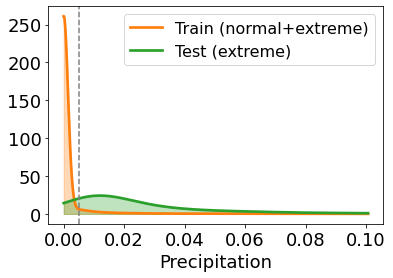

In [337]:
train_rain = train_X[:50000, 0, 0]
test_rain_extreme = test_X_mask_extreme[:, 0, 0]

# Perform kernel density estimation
kde_train_NE = gaussian_kde(train_rain)
kde_test_E = gaussian_kde(test_rain_extreme)

# Create a range of values for the x-axis
x = np.linspace(min(train_rain), max(train_rain)-0.4, 1000)
# x = np.linspace(min(train_rain), max(train_rain)-0.4, 1000)

# Calculate the estimated PDF values for the x-axis range
pdf_train_NE = kde_train_NE(x)
pdf_test_E = kde_test_E(x)


FONTSIZE = 18
TICKSIZE = 18
LINEWIDTH = 2.7

# Plot the estimated PDF
# Plot the estimated PDF
plt.plot(x, pdf_train_NE, linewidth=LINEWIDTH, color='C1', label='Train (normal+extreme)') 
plt.plot(x, pdf_test_E,  linewidth=LINEWIDTH, color='C2', label='Test (extreme)')

# Fill area under the curve for pdf_train_NE
plt.fill_between(x, pdf_train_NE, color='C1', alpha=0.3)
plt.fill_between(x, pdf_test_E, color='C2', alpha=0.3)


plt.axvline(x=percentile_rain, color='gray', linestyle='--')
# plt.title("Water Level Dataset", fontsize=FONTSIZE)
plt.xlabel("Precipitation", fontsize=FONTSIZE)
# plt.ylabel("PDF", fontsize=FONTSIZE)
plt.xticks(fontsize=TICKSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE-2)
plt.savefig('figures/pdf_prep.jpg', bbox_inches='tight', dpi=300)
plt.show()

## Price

In [338]:
dataset = pd.read_csv('../data/energy_weather.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
# data


values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))

# train_X = scaler.fit_transform(train_X)
# train_y = scaler.fit_transform(train_y)

# val_X = scaler.fit_transform(val_X)
# val_y = scaler.fit_transform(val_y)

# test_X = scaler.fit_transform(test_X)
# test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


train_X_extreme = train_X[train_X_pm > percentile_pm]
train_y_extreme = train_y[train_X_pm > percentile_pm]

train_X_normal = train_X[train_X_pm <= percentile_pm]
train_y_normal = train_y[train_X_pm <= percentile_pm]

print("train_X_extreme, train_X_normal", train_X_extreme.shape, train_X_normal.shape)

test_X_extreme = test_X[test_X_pm > percentile_pm]
test_y_extreme = test_y[test_X_pm > percentile_pm]

test_X_normal = test_X[test_X_pm <= percentile_pm]
test_y_normal = test_y[test_X_pm <= percentile_pm]

95th Percentile of Daily Rain: 79.18
train_X_extreme, train_X_normal (1004, 72, 26) (23482, 72, 26)


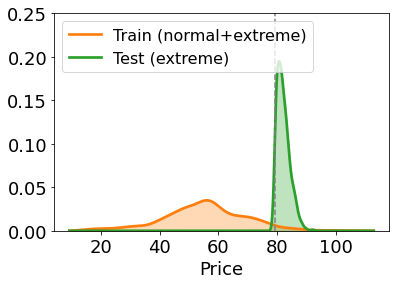

In [339]:
train_rain = train_X_pm
test_rain_extreme = test_X_extreme[:, 0, feature_idx]

# Perform kernel density estimation
kde_train_NE = gaussian_kde(train_rain)
kde_test_E = gaussian_kde(test_rain_extreme)

# Create a range of values for the x-axis
x = np.linspace(min(train_rain), max(train_rain), 1000)

# Calculate the estimated PDF values for the x-axis range
pdf_train_NE = kde_train_NE(x)
pdf_test_E = kde_test_E(x)


FONTSIZE = 18
TICKSIZE = 18
LINEWIDTH = 2.7

# Plot the estimated PDF
# Plot the estimated PDF
plt.plot(x, pdf_train_NE, linewidth=LINEWIDTH, color='C1', label='Train (normal+extreme)') 
plt.plot(x, pdf_test_E,  linewidth=LINEWIDTH, color='C2', label='Test (extreme)')

# Fill area under the curve for pdf_train_NE
plt.fill_between(x, pdf_train_NE, color='C1', alpha=0.3)
plt.fill_between(x, pdf_test_E, color='C2', alpha=0.3)


plt.axvline(x=percentile_pm, color='gray', linestyle='--')
# plt.title("Price", fontsize=FONTSIZE)
plt.xlabel("Price", fontsize=FONTSIZE)
# plt.ylabel("PDF", fontsize=FONTSIZE)
plt.xticks(fontsize=TICKSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.ylim(0, 0.25)
plt.legend(fontsize=FONTSIZE-2, loc='upper left')
plt.savefig('figures/pdf_price.jpg', bbox_inches='tight', dpi=300)
plt.show()

## Electricity load

In [9]:
dataset = pd.read_csv('../data/energy_weather.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
# data


values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 4
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))

# train_X = scaler.fit_transform(train_X)
# train_y = scaler.fit_transform(train_y)

# val_X = scaler.fit_transform(val_X)
# val_y = scaler.fit_transform(val_y)

# test_X = scaler.fit_transform(test_X)
# test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


train_X_extreme = train_X[train_X_pm > percentile_pm]
train_y_extreme = train_y[train_X_pm > percentile_pm]

train_X_normal = train_X[train_X_pm <= percentile_pm]
train_y_normal = train_y[train_X_pm <= percentile_pm]

print("train_X_extreme, train_X_normal", train_X_extreme.shape, train_X_normal.shape)

test_X_extreme = test_X[test_X_pm > percentile_pm]
test_y_extreme = test_y[test_X_pm > percentile_pm]

test_X_normal = test_X[test_X_pm <= percentile_pm]
test_y_normal = test_y[test_X_pm <= percentile_pm]

95th Percentile of Daily Rain: 36091.049999999996
train_X_extreme, train_X_normal (1097, 72, 26) (23389, 72, 26)


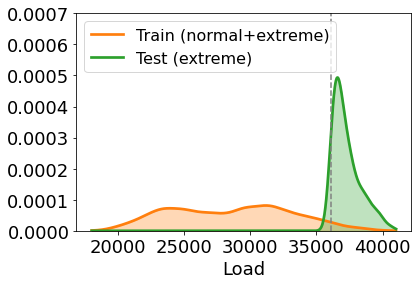

In [14]:
train_rain = train_X_pm
test_rain_extreme = test_X_extreme[:, 0, feature_idx]

# Perform kernel density estimation
kde_train_NE = gaussian_kde(train_rain)
kde_test_E = gaussian_kde(test_rain_extreme)

# Create a range of values for the x-axis
x = np.linspace(min(train_rain), max(train_rain), 1000)

# Calculate the estimated PDF values for the x-axis range
pdf_train_NE = kde_train_NE(x)
pdf_test_E = kde_test_E(x)

FONTSIZE = 18
TICKSIZE = 18
LINEWIDTH = 2.7

# Plot the estimated PDF
plt.plot(x, pdf_train_NE, linewidth=LINEWIDTH, color='C1', label='Train (normal+extreme)') 
plt.plot(x, pdf_test_E,  linewidth=LINEWIDTH, color='C2', label='Test (extreme)')

# Fill area under the curve for pdf_train_NE
plt.fill_between(x, pdf_train_NE, color='C1', alpha=0.3)
plt.fill_between(x, pdf_test_E, color='C2', alpha=0.3)


plt.axvline(x=percentile_pm, color='gray', linestyle='--')
# plt.title("Load", fontsize=FONTSIZE)
plt.xlabel("Load", fontsize=FONTSIZE)
# plt.ylabel("PDF", fontsize=FONTSIZE)
plt.xticks(fontsize=TICKSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.ylim(0, 0.0007)
plt.legend(fontsize=FONTSIZE-2, loc='upper left')
plt.savefig('figures/pdf_load.jpg', bbox_inches='tight', dpi=300)
plt.show()

## Pressure

In [342]:
data = pd.read_csv("../data/jena_climate_2009_2016_hourly.csv", index_col=0)
data.fillna(0, inplace=True)


values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 5
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))

# train_X = scaler.fit_transform(train_X)
# train_y = scaler.fit_transform(train_y)

# val_X = scaler.fit_transform(val_X)
# val_y = scaler.fit_transform(val_y)

# test_X = scaler.fit_transform(test_X)
# test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


train_X_extreme = train_X[train_X_pm > percentile_pm]
train_y_extreme = train_y[train_X_pm > percentile_pm]

train_X_normal = train_X[train_X_pm <= percentile_pm]
train_y_normal = train_y[train_X_pm <= percentile_pm]


print("train_X_extreme, train_X_normal", train_X_extreme.shape, train_X_normal.shape)

test_X_extreme = test_X[test_X_pm > percentile_pm]
test_y_extreme = test_y[test_X_pm > percentile_pm]

test_X_normal = test_X[test_X_pm <= percentile_pm]
test_y_normal = test_y[test_X_pm <= percentile_pm]

95th Percentile of Daily Rain: 28.341250000000002
train_X_extreme, train_X_normal (2297, 72, 14) (46735, 72, 14)


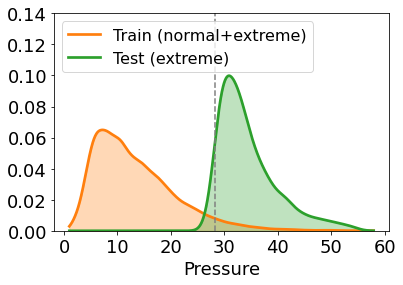

In [343]:
train_rain = train_X_pm
test_rain_extreme = test_X_extreme[:, 0, feature_idx]

# Perform kernel density estimation
kde_train_NE = gaussian_kde(train_rain)
kde_test_E = gaussian_kde(test_rain_extreme)

# Create a range of values for the x-axis
x = np.linspace(min(train_rain), max(train_rain), 1000)

# Calculate the estimated PDF values for the x-axis range
pdf_train_NE = kde_train_NE(x)
pdf_test_E = kde_test_E(x)


FONTSIZE = 18
TICKSIZE = 18
LINEWIDTH = 2.7

# Plot the estimated PDF
plt.plot(x, pdf_train_NE, linewidth=LINEWIDTH, color='C1', label='Train (normal+extreme)') 
plt.plot(x, pdf_test_E,  linewidth=LINEWIDTH, color='C2', label='Test (extreme)')

# Fill area under the curve for pdf_train_NE
plt.fill_between(x, pdf_train_NE, color='C1', alpha=0.3)
plt.fill_between(x, pdf_test_E, color='C2', alpha=0.3)


plt.axvline(x=percentile_pm, color='gray', linestyle='--')
# plt.title("Climate Dataset", fontsize=FONTSIZE)
plt.xlabel("Pressure", fontsize=FONTSIZE)
# plt.ylabel("PDF", fontsize=FONTSIZE)
plt.xticks(fontsize=TICKSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.ylim(0, 0.14)
plt.legend(fontsize=FONTSIZE-2, loc='upper left')
plt.savefig('figures/pdf_pressure.jpg', bbox_inches='tight', dpi=300)
plt.show()

## PM25

In [344]:
data = pd.read_csv("../data/pollution.csv", index_col=0)
data.fillna(0, inplace=True)

values = data.values
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)

# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))

# train_X = scaler.fit_transform(train_X)
# train_y = scaler.fit_transform(train_y)

# val_X = scaler.fit_transform(val_X)
# val_y = scaler.fit_transform(val_y)

# test_X = scaler.fit_transform(test_X)
# test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


train_X_pm = train_X[:, 0, feature_idx]
val_X_pm = val_X[:, 0, feature_idx]
test_X_pm = test_X[:, 0, feature_idx]


percentile = 95
merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))
percentile_pm = np.percentile(merged_array, percentile)
print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)


train_X_extreme = train_X[train_X_pm > percentile_pm]
train_y_extreme = train_y[train_X_pm > percentile_pm]

train_X_normal = train_X[train_X_pm <= percentile_pm]
train_y_normal = train_y[train_X_pm <= percentile_pm]


print("train_X_extreme, train_X_normal", train_X_extreme.shape, train_X_normal.shape)

test_X_extreme = test_X[test_X_pm > percentile_pm]
test_y_extreme = test_y[test_X_pm > percentile_pm]

test_X_normal = test_X[test_X_pm <= percentile_pm]
test_y_normal = test_y[test_X_pm <= percentile_pm]

95th Percentile of Daily Rain: 281.0
train_X_extreme, train_X_normal (1499, 72, 11) (29102, 72, 11)


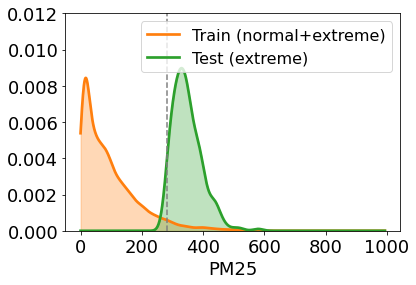

In [345]:
train_rain = train_X_pm
test_rain_extreme = test_X_extreme[:, 0, feature_idx]

# Perform kernel density estimation
kde_train_NE = gaussian_kde(train_rain)
kde_test_E = gaussian_kde(test_rain_extreme)

# Create a range of values for the x-axis
x = np.linspace(min(train_rain), max(train_rain), 1000)

# Calculate the estimated PDF values for the x-axis range
pdf_train_NE = kde_train_NE(x)
pdf_test_E = kde_test_E(x)


FONTSIZE = 18
TICKSIZE = 18
LINEWIDTH = 2.7

# Plot the estimated PDF
plt.plot(x, pdf_train_NE, linewidth=LINEWIDTH, color='C1', label='Train (normal+extreme)') 
plt.plot(x, pdf_test_E,  linewidth=LINEWIDTH, color='C2', label='Test (extreme)')

# Fill area under the curve for pdf_train_NE
plt.fill_between(x, pdf_train_NE, color='C1', alpha=0.3)
plt.fill_between(x, pdf_test_E, color='C2', alpha=0.3)

plt.axvline(x=percentile_pm, color='gray', linestyle='--')
# plt.title("Climate Dataset", fontsize=FONTSIZE)
plt.xlabel("PM25", fontsize=FONTSIZE)
# plt.ylabel("PDF", fontsize=FONTSIZE)
plt.xticks(fontsize=TICKSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.ylim(0, 0.012)
plt.legend(fontsize=FONTSIZE-2, loc='best')
plt.savefig('figures/pdf_pm25.jpg', bbox_inches='tight', dpi=300)
plt.show()